In [ ]:
import pandas as pd

In [ ]:
# Load the weekly summary
df = pd.read_csv("macro_weekly_summary.csv")

In [ ]:
# Step 1: Remove invalid rows (e.g., 0 users)
df = df[df['users_covered'] > 0]

In [ ]:
# Step 2: Aggregate CVR per week (across all discount buckets)
cvr_df = df.groupby('week').agg({'expected_conversions': 'sum', 'users_covered': 'sum'}).reset_index()
cvr_df['CVR'] = cvr_df['expected_conversions'] / cvr_df['users_covered']

In [ ]:
# Step 3: Prepare for Prophet
df_cvr_prophet = cvr_df[['week', 'CVR']].copy()
df_cvr_prophet.columns = ['ds', 'y']
df_cvr_prophet['ds'] = pd.to_datetime(df_cvr_prophet['ds'].str.split('/').str[0])

In [ ]:
# Step 4: Prepare for LSTM (just the CVR values in sequence)
df_cvr_lstm = df_cvr_prophet[['ds', 'y']].copy()

In [ ]:
# Optional: Preview
print("✅ Prophet-ready CVR data:")
print(df_cvr_prophet)

print("\n✅ LSTM-ready CVR series:")
print(df_cvr_lstm['y'].values)

✅ Prophet-ready CVR data:
          ds         y
0 2020-12-28  0.386701
1 2021-01-04  0.423560
2 2021-01-11  0.446955
3 2021-01-18  0.436896
4 2021-01-25  0.439964
5 2021-02-01  0.436756
6 2021-02-08  0.418494
7 2021-02-15  0.417959
8 2021-02-22  0.405518
9 2021-03-01  0.346783

✅ LSTM-ready CVR series:
[0.38670104 0.42355998 0.44695506 0.43689607 0.43996429 0.43675603
 0.41849385 0.41795945 0.40551823 0.34678289]


In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Instantiate and fit the model
model = Prophet()
model.fit(df_cvr_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjd47tunx/fteyvulc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjd47tunx/h99orinu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12783', 'data', 'file=/tmp/tmpjd47tunx/fteyvulc.json', 'init=/tmp/tmpjd47tunx/h99orinu.json', 'output', 'file=/tmp/tmpjd47tunx/prophet_modeluoiywh4i/prophet_model-20250620173825.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:38:25 - cmdstanpy - INFO - Chain [1] start processing
IN

In [ ]:
# Step 2: Create a future dataframe
future = model.make_future_dataframe(periods=4, freq='W-MON')

In [ ]:
# Step 3: Forecast
forecast = model.predict(future)

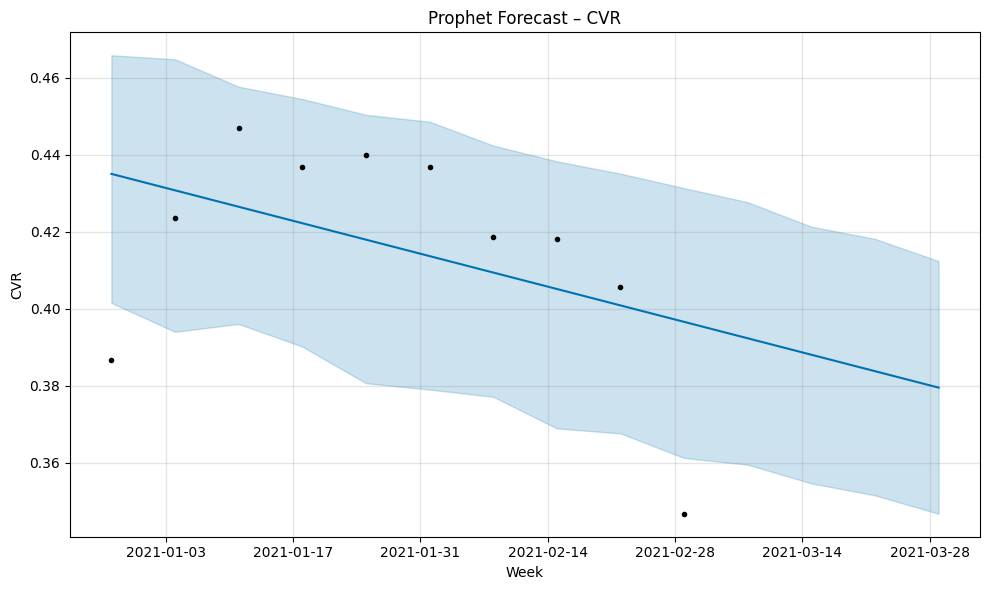

In [ ]:
# Step 4: Plot
model.plot(forecast)
plt.title("Prophet Forecast – CVR")
plt.xlabel("Week")
plt.ylabel("CVR")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Step 5: View forecasted CVR values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(4)

,ds,yhat,yhat_lower,yhat_upper
10,2021-03-08,0.392303,0.359500,0.427635
11,2021-03-15,0.388035,0.354641,0.421280
12,2021-03-22,0.383767,0.351536,0.418117
13,2021-03-29,0.379499,0.346748,0.412347


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Step 1: Get CVR series
cvr_series = df_cvr_lstm['y'].values.reshape(-1, 1)

In [ ]:
# Step 2: Scale CVR to 0-1
scaler = MinMaxScaler()
scaled_cvr = scaler.fit_transform(cvr_series)

In [ ]:
# Step 3: Prepare sequences (8 weeks → next 1)
X, y = [], []
sequence_length = 4  # Try with 4 weeks to predict next
for i in range(len(scaled_cvr) - sequence_length):
    X.append(scaled_cvr[i:i + sequence_length])
    y.append(scaled_cvr[i + sequence_length])

X = np.array(X)
y = np.array(y)

In [ ]:
# Reshape input for LSTM: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
# Step 4: Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Step 5: Train the model
model.fit(X, y, epochs=200, verbose=0)

In [ ]:
# Step 6: Forecast future CVR (next 4 weeks)
future_steps = 4
last_seq = scaled_cvr[-sequence_length:].reshape(1, sequence_length, 1)
predictions = []
for _ in range(future_steps):
    pred = model.predict(last_seq)[0][0]
    predictions.append(pred)
    last_seq = np.append(last_seq[:, 1:, :], [[[pred]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


In [ ]:
# Step 7: Inverse transform to get original CVR values
predicted_cvr = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

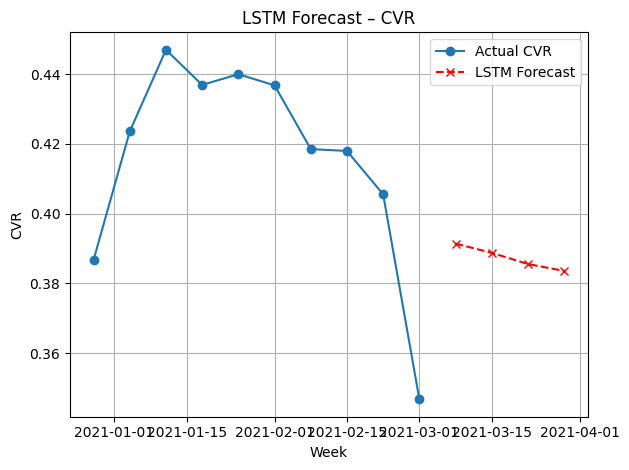

In [ ]:
# Step 8: Plot
weeks_future = pd.date_range(start=df_cvr_lstm['ds'].iloc[-1] + pd.Timedelta(weeks=1), periods=future_steps, freq='W-MON')
plt.plot(df_cvr_lstm['ds'], df_cvr_lstm['y'], marker='o', label='Actual CVR')
plt.plot(weeks_future, predicted_cvr, marker='x', linestyle='--', color='red', label='LSTM Forecast')
plt.title("LSTM Forecast – CVR")
plt.xlabel("Week")
plt.ylabel("CVR")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Step 9: Print predicted values
for date, val in zip(weeks_future, predicted_cvr.flatten()):
    print(f"{date.date()} → Predicted CVR: {val:.4f}")

2021-03-08 → Predicted CVR: 0.3914
2021-03-15 → Predicted CVR: 0.3887
2021-03-22 → Predicted CVR: 0.3856
2021-03-29 → Predicted CVR: 0.3836


Testing

In [ ]:
actual = [0.4055, 0.3468]           # real CVR values
prophet_pred = [0.4121, 0.3795]     # Prophet predicted
lstm_pred = [0.4083, 0.3842]        # LSTM predicted

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [ ]:
# Prophet accuracy
mae_prophet = mean_absolute_error(actual, prophet_pred)
rmse_prophet = np.sqrt(mean_squared_error(actual, prophet_pred))

In [ ]:
# LSTM accuracy
mae_lstm = mean_absolute_error(actual, lstm_pred)
rmse_lstm = np.sqrt(mean_squared_error(actual, lstm_pred))

print(f"📈 Prophet → MAE: {mae_prophet:.4f}, RMSE: {rmse_prophet:.4f}")
print(f"🧠 LSTM    → MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")

📈 Prophet → MAE: 0.0197, RMSE: 0.0236
🧠 LSTM    → MAE: 0.0201, RMSE: 0.0265
